# Relax Challenge - Data Science Interview

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
#load engagement data
eng = pd.read_csv('takehome_user_engagement.csv')

In [3]:
#check engagement
eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
#check data types
eng.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [5]:
#create date column
eng['time_stamp'] = pd.to_datetime(eng['time_stamp'])
eng['date'] = eng.time_stamp.dt.floor('D')
eng_cleaned = eng.drop(columns=['time_stamp'])

In [6]:
#create 7 day rolling visit count
eng_cleaned['visit_7d'] = eng_cleaned.sort_values(by=['date']).groupby(['user_id'])['visited'].rolling(3, min_periods = 1).sum().reset_index(drop=True, level=0)

In [7]:
#create 2 visits later date column
eng_cleaned['two_visits_later'] = eng_cleaned.sort_values(by=['date']).groupby(['user_id'])['date'].shift(-2)

In [8]:
#calculate difference between first and third visit
eng_cleaned['day_diff'] = (eng_cleaned.two_visits_later - eng_cleaned.date).dt.days

In [9]:
#create adopted boolean
eng_cleaned['adopted'] = eng_cleaned.day_diff.apply(lambda x: True if x <=7 else False)

In [10]:
#create merge table
eng_merge = pd.DataFrame(eng_cleaned.groupby(['user_id'])['adopted'].sum().apply(lambda x: True if x >0 else False))

In [11]:
#load user data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [12]:
#create join key
users = users.rename(columns={'object_id':'user_id'})

In [13]:
#join dataframes
df = users.merge(eng_merge, on='user_id')

In [14]:
#check join
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [15]:
#check for duplicates
df.duplicated().sum()

0

In [16]:
#check for null values
df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopted                          0
dtype: int64

In [17]:
#create boolean for if user was invited by another user
df['invited_by_user'] =  df.invited_by_user_id.notnull().astype('int')

#drop redundant/irrelevant columns
df.drop(columns=['invited_by_user_id', 'name', 'last_session_creation_time'], inplace=True)

In [18]:
#number of unique users
num_users = df.user_id.nunique()
print('number of users: ', num_users)

#number of adopted user
num_adopted = df.adopted.sum()
print('number of adopted users: ', num_adopted)

#percent adoption
perc_adopted = num_adopted / num_users * 100
print('percent of users who adopted: ', perc_adopted)

number of users:  8823
number of adopted users:  1656
percent of users who adopted:  18.769126147568855


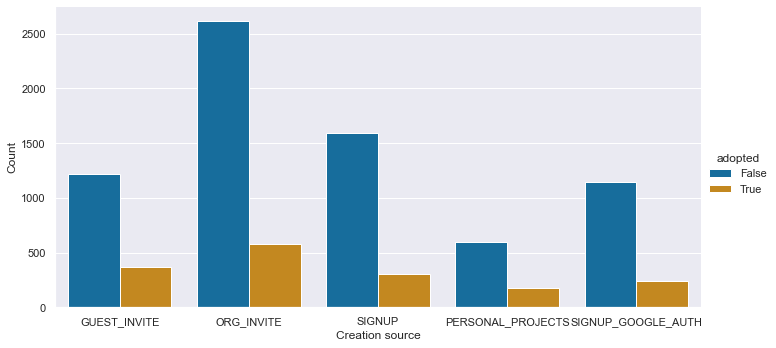

In [19]:
#plot creation source by adoption
sns.set(style='darkgrid', palette='colorblind')
sns.catplot(data=df, x='creation_source', kind='count', aspect=2, hue='adopted')
plt.xlabel('Creation source')
plt.ylabel('Count')
plt.show()

In [20]:
#change date types
df.creation_time = pd.to_datetime(df.creation_time).dt.date

In [21]:
#change other columns
df = df.astype({'org_id': 'object'})
df.set_index('user_id', inplace=True)

In [22]:
#check email
df.email = df.email.apply(lambda x: x.split('@')[1])
print('top email: ')
print(df.email.value_counts().head(10))

top email: 
gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
hotmail.com        803
luque.com            2
mumdc.com            2
oqpze.com            2
xybhi.com            2
Name: email, dtype: int64


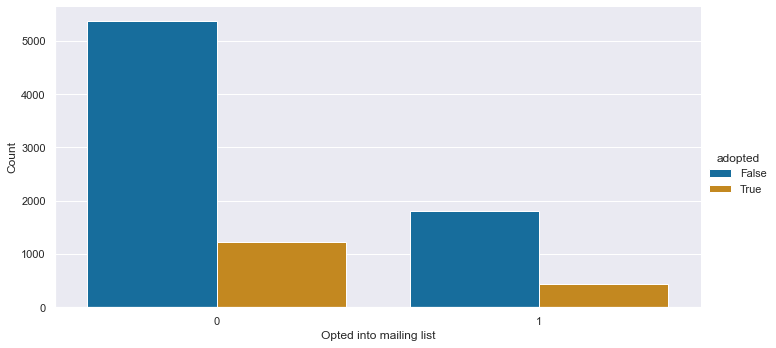

In [23]:
#plot mailing list opt in distribution by adoption
sns.catplot(data=df, x='opted_in_to_mailing_list', kind='count', aspect=2, hue='adopted')
plt.xlabel('Opted into mailing list')
plt.ylabel('Count')
plt.show()

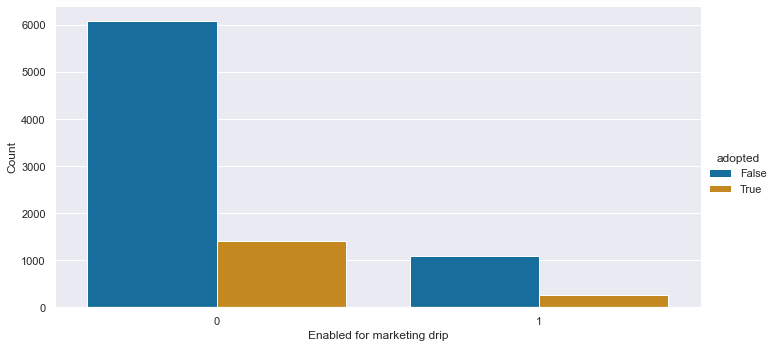

In [24]:
#plot marketing drip enabled distribution by adoption
sns.catplot(data=df, x='enabled_for_marketing_drip', kind='count', aspect=2, hue='adopted')
plt.xlabel('Enabled for marketing drip')
plt.ylabel('Count')
plt.show()

In [25]:
#one hot encode categorical features
cat = df.select_dtypes(['object']).columns
df = pd.get_dummies(df, columns=cat)

In [26]:
#split target variable
y = df.adopted
X = df.drop('adopted', axis=1)

In [27]:
#split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

In [28]:
#instantiate and fit decision tree classifier 
dtc = DecisionTreeClassifier(max_depth=20, random_state=14)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=14)

In [29]:
#make predictions and score accuracy
train_pred = dtc.predict(X_train)
test_pred = dtc.predict(X_test)
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
print('training accuracy: ', train_accuracy)
print('testing accuracy: ', test_accuracy)

training accuracy:  0.8320919689119171
testing accuracy:  0.8182848507744617


In [30]:
#list most important features
feature_imps = pd.DataFrame(zip(X.columns, dtc.feature_importances_), columns=['feature','importance'])
print(feature_imps.sort_values(by='importance',ascending=False).head(5))

                                feature  importance
249            creation_time_2013-02-01    0.034803
1545       creation_source_GUEST_INVITE    0.030351
1547  creation_source_PERSONAL_PROJECTS    0.025627
964                   email_hotmail.com    0.024372
130            creation_time_2012-10-05    0.023880


### Findings:
* Of the 8223 users, 1656 'adopted' (logged in at least 3 times in some 7 day period), a 18.8% conversion
* The most important features are listed above, including two creation sources: Guest Invite and Personal Projects
* More research can be done into acquisition campaigns corresponding to the creation time dates
* The company can look into the organizations corresponding to the ids for inroads to new users

### Notes:
* A Decision Tree Classifier was used for visibility into feature importances and strong performance in modeling (around 82% accuracy)
